In [1]:
# Libraries
import numpy as np
import astropy.units as u
from astropy.constants import G

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
from tqdm import tqdm

# Set plotting rcParams
fontsize = 18
label_size = fontsize

matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# my modules
from ReadFile import Read
from MassProfile import MassProfile
from CenterOfMass import CenterOfMass

# ASTR 400B: Research Assignment
By: Colton Quirk

1. Topic of Research Assignment

   How the tidal forces affect the rotation curve of M31 and the MW.
   
2. One Question


   Evolution of M31 Rotation Curve over time

3. One Plot to Create

   Animation of M31 rotation curve over time

## Outline of the Code

1. Read in data
2. Compute MassDerived Rotation curve and Line of Sight rotation curve
3. Make an animation showing how this changes over time

## To Do:

1. Add functionality to analyze Disk and Bulge Particles

In [2]:
def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) 
            such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) 
            such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    
    # normalize the angular momentum vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to
    # z unit vector (disk in xy-plane)
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [3]:
def Relative_Pos_Vel(COMD):
    """
    Function to compute the position and velocity of the particles relative to the Center of Mass.

    Input:
        COMD: Center of Mass Object for a specific particle type

    Output:
        r: positions of the particles relative to the Center of Mass
        v: velocities of the particles relative to the Center of Mass
    """
    # Compute COM of the Galaxy using disk particles
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 
    
    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)
    
    # Determine velocities of disk particles relative to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 
    
    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
    
    # Arrays for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T

    return r, v

In [4]:
def Cylindrical_Coords(rn, vn):
    """
    Function to transform cartesian coordinates to cylindrical coordinates

    Inputs:
        rn: position of particles in cartesian coordinates
        vn: velocities of particles in cartesian coordinates

    Outputs:
        rho: radial position of the particles
        vr:  radial velocity of the particles
        vphi: velocity of the particles in the phi direction
    """
    # radius 
    rho = np.sqrt(rn[:,0]**2 + rn[:,1]**2)
    
    # velocity in cylindrical coordinates. 
    # radius 
    rho = np.sqrt(rn[:,0]**2 + rn[:,1]**2) 
    
    # radial velocity 
    vr = (rn[:,0] * vn[:,0] + rn[:,1] * vn[:,1]) / rho
    
    # azimuthal velocity
    vphi = (rn[:,0] *  vn[:,1] - rn[:,1] * vn[:,0]) / rho

    return rho, vr, vphi

In [5]:
class Rotation_Curves:
    def __init__(self, Galaxy_Name, snap_ids, r_start=0.01, r_end=45, dr = 0.1, Res="VLowRes"):
        """
        Class to compute the Rotation Curves of the specified galaxy

        Inputs:
            Galaxy_Name: Name of the galaxy to be analyzed
                        e.g "MW" or "M31"
            snap_ids: Array of numbers that specify the snapshots of the data to analyze
            r_start: starting radius to analyze the rotation curve from
            r_end:   ending radius to analyze the rotation curve
            dr:      spacing of the radial bins
            High_Res: Boolean to decide whether to use High Resolution data or not
        """
        # Store the galaxy name and snap ids to measure
        self.gname = Galaxy_Name
        self.snap_ids = snap_ids

        # Create list of files names and path for the data
        if Res=="VLowRes":
            path = f"VLowRes\\{Galaxy_Name}\\"
            fnames = [f"{Galaxy_Name}_{snap_id:0>3}.txt" for snap_id in self.snap_ids]
            M31_NumP = 60000
            MW_NumP = 37500
        elif Res=="LowRes": 
            path = f"LowRes\\{Galaxy_Name}\\"
            fnames = [f"{Galaxy_Name}_{snap_id:0>3}.txt" for snap_id in self.snap_ids]
            M31_NumP = 120000
            MW_NumP = 75000
        elif Res=="HighRes":
            path = f"HighRes\\{Galaxy_Name}\\"
            fnames = [f"{Galaxy_Name}_{snap_id:0>3}.txt" for snap_id in self.snap_ids]
            M31_NumP = 240000
            MW_NumP = 150000
        else:
            print(f"Resolution {Res} is not a valid resolution type.")

        self.path = path
        self.fnames = fnames

        # General radii for plotting/fitting
        # Positions for MassProfile
        # And Positions for "Observed" Rotation Curve
        self.dr = dr
        self.radii = np.arange(r_start, r_end, dr)

        # Derived from MassProfile
        # Initialize an array of circular velocities for the mass derived rotation curve
        self.Vcircs = np.zeros((self.snap_ids.shape[0], self.radii.shape[0]))

        # Observed Values
        # Initizlize an array for the observed rotation curve
        self.v2s = np.zeros((self.snap_ids.shape[0], self.radii.shape[0]))

        # rhos and vphis for observed rotation curve
        # WHERE DOES 60000 come from!?! Needs to be programatic
        if self.gname == "M31":
            self.rhos = np.zeros((self.snap_ids.shape[0], M31_NumP))
            self.vphis = np.zeros((self.snap_ids.shape[0], M31_NumP))
        elif self.gname == "MW":
            self.rhos = np.zeros((self.snap_ids.shape[0], MW_NumP))
            self.vphis = np.zeros((self.snap_ids.shape[0], MW_NumP))
            
    def Calculate_Rotation_Curves(self):
        """
        Function to calculate the rotation curves of the galaxy
        """
        # Loop over all snap_ids to make a rotation curve for each one
        for i, snap_id in enumerate(tqdm(self.snap_ids)):
            fname = self.fnames[i]
    
            # create a mass profile object for the Galaxy
            Profile = MassProfile(self.path+self.gname, snap_id)
            # Circular velocity profile
            Vcirc = Profile.CircularVelocityTotal(self.radii)
            # Store the Calculated Circular Velocity Profile
            self.Vcircs[i] = Vcirc
    
            # Create a Center Of Mass Object for the file
            # use Disk Particles (ptype=2)
            COMD = CenterOfMass(self.path+fname,2)
            # Get the positions and velocities relative to the center of mass
            r, v = Relative_Pos_Vel(COMD)
            # compute the rotated position and velocity vectors
            rn, vn = RotateFrame(r, v)
            # Convert to cylindrical coordinates
            rho, vr, vphi = Cylindrical_Coords(rn, vn)

            # Determine the mean vphi per radius
            # Initialize Empty Array for Velocity 
            # (same size as radial array)
            v2 = np.zeros_like(self.radii) 
            # compute the mean vphi in radial bins
            for j, radius in enumerate(self.radii):
                index = np.where((rho > radius) & (rho < radius+self.dr)) # walking out in radial bins
                v2[j] = np.mean(np.abs(vphi[index])) # mean velocity

            # Store the observed rotation curves
            self.v2s[i] = v2
            # Sore the rotation curves in cylindrical coordinates
            self.rhos[i] = rho
            self.vphis[i] = np.abs(vphi)

    def RMSD(self):
        """
        Function to compute the Root Mean Square Deviations from the initial snapshot
        """
        # Calculate the deviation from the initial rotation curve
        delta = self.v2s - self.v2s[0, :]
        # Square the deviations
        squared = delta**2
        # Take the mean of the deviations for each snapshot
        mean_squared = np.mean(squared, axis=1)
        # Take the square root of the mean squared deviations
        rmsd = np.sqrt(mean_squared)
        # Store the root mean square deviations
        self.rmsd = rmsd

    def RMSD_Circular_vs_Observed(self):
        """
        Function to compute the Root Mean Square Deviation between the observed and mass-derived
            rotation curves for each snapshot
        """
        # Calculate the deviation between the observed and mass derived rotation curves
        delta = self.v2s - self.Vcircs
        # Square the deviations
        squared = delta**2
        # Take the mean of the deviations for each snapshot
        mean_squared = np.mean(squared, axis=1)
        # Take the square root of the mean square deviations
        rmsd = np.sqrt(mean_squared)
        # Store the root mean squared deviations between Mass derived and observed curves
        self.rmsd_MvO = rmsd
        

    def plot_all_curves(self, save=False):
        """
        Function to plot the rotation curves and their difference from the initial
            rotation curve, the first snap_id in the snap_ids list.
        """
        # Normalize for colorbar
        norm = mcolors.Normalize(vmin=np.min(self.snap_ids), vmax=np.max(self.snap_ids))
        cmap = cm.plasma

        fig, ax = plt.subplots(2, 1, figsize=(1.2*6, 2*6), layout="constrained")
        for i, snap_id in enumerate(self.snap_ids):
            color = cmap(norm(snap_id))
            ax[0].plot(self.radii, self.v2s[i], c=color, label=f"{snap_id:0>3}")
            ax[1].plot(self.radii, self.v2s[i] - self.v2s[0], c=color, label=f"{snap_id:0>3}")

        ax[0].set_xlabel('R (kpc)', fontsize=fontsize)
        ax[0].set_ylabel(r'v$_\phi$ (km/s)', fontsize=fontsize)
        ax[0].set_title(f"Observed Rotation Curves of {self.gname}", fontsize=fontsize)
        #  ax[0].legend()

        ax[1].set_xlabel('R (kpc)', fontsize=fontsize)
        ax[1].set_ylabel(r'Difference in Velocity v$_\phi$ (km/s)', fontsize=fontsize)
        ax[1].set_title(f"Difference from Original Rotation Curve of {self.gname}", fontsize=fontsize)
        # ax[1].legend()

        # Only add colorbar to ax1
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Needed for colorbar
        
        cbar = fig.colorbar(sm, ax=ax[0])
        cbar.set_label('Snap Number', fontsize=fontsize)

        cbar = fig.colorbar(sm, ax=ax[1])
        cbar.set_label('Snap Number', fontsize=fontsize)
        if save:
            fig.savefig(f"{self.gname}_Diff_Curves.png")
        plt.show()

    def plot(self, snap_id, xlim=100, plot = True, save=False):
        """
        Function to plot the observed and mass derived rotation curves
        Inputs:
            snap_id: Which snapshot to plot the rotation curve of
            xlim:    Limit on the x-axis for the plot
            save:    Boolean to determine whether to save the plots or not
        """
        index = np.where(self.snap_ids == snap_id)[0][0]

        Vcirc = self.Vcircs[index]

        v2 = self.v2s[index]
        rho = self.rhos[index]
        vphi = self.vphis[index]

        fig, ax = plt.subplots(figsize=(1.2*6, 6), layout="constrained")
        ax.plot(self.radii, Vcirc, color="Red", lw=2, linestyle="--", label="Mass Derived Rotation Curve")
        ax.plot(self.radii, v2, color="Blue", lw=2, linestyle="-", label="Average from 'Observed' Curve")
        plt.hist2d(rho, np.abs(vphi), bins=150, norm=LogNorm())
        plt.colorbar()

        ax.set_xlabel('R (kpc)', fontsize=fontsize)
        ax.set_ylabel(r'v$_\phi$ (km/s)', fontsize=fontsize)
        ax.set_title(f"Rotation Curve of {self.gname} at snap number {snap_id:0>3}", fontsize=fontsize)
        ax.legend()
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, 500)

        if save:
            fig.savefig(f"{self.gname}_Plots\\Rotation_Curves\\{self.gname}_{snap_id:0>3}_rotation_curve.png")
            
        if plot:
            plt.show()

In [6]:
def separations(snap_ids, Res="VLowRes"):
    """
    Function to compute the separation between MW and M31 Center of Masses
    for a given array of snap_ids

    Inputs:
        snap_ids: array of snap_ids to compute the separatoin of
        Res: Resolution of data to use, either "VLowRes", "LowRes", or "HighRes"

    Outputs:
        seps: Array of separations for the snap_ids
    """
    # Initialize an array to store the separations
    seps = np.zeros_like(snap_ids)
    # Create list of files names and path for the data
    path_M31 = f"{Res}\\M31\\"
    fnames_M31 = [f"M31_{snap_id:0>3}.txt" for snap_id in snap_ids]
    path_MW= f"{Res}\\MW\\"
    fnames_MW = [f"MW_{snap_id:0>3}.txt" for snap_id in snap_ids]

    # For each snapshot calculate the positions of the Center of Mass
    #    for both M31 and MW
    # Then calculate the distance between those points
    # Store that value in the array
    for i, snap_id in enumerate(tqdm(snap_ids)):
        fname_M31 = fnames_M31[i]
        COMD_M31 = CenterOfMass(path_M31+fname_M31,2) 
        COM_P_M31 = COMD_M31.COM_P(0.1).value
        
        fname_MW = fnames_MW[i]
        COMD_MW = CenterOfMass(path_MW+fname_MW,2) 
        COM_P_MW = COMD_MW.COM_P(0.1).value

        seps[i] = np.linalg.norm(COM_P_M31 - COM_P_MW)

    return seps
        

In [7]:
# Snap ids
# Need one "initial" snap
# One before the close approach
# One "during" the close approach
# One after the close approach
# and then one far from
# snap_ids = np.array([0, 200, 280, 360, 400])
snap_ids = np.arange(0, 335+1, 10, dtype=int)
print(snap_ids)
# snap_ids = np.arange(0, 500, 50, dtype=int)
# snap_ids = np.append(snap_ids, np.arange(500, 900, 100, dtype=int))
# np.arange(0, 802, 1, dtype=int)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330]


In [8]:
# Calculate the separations for the chosen snapshots
seps = separations(snap_ids, Res="LowRes")
print(seps)

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [02:01<00:00,  3.57s/it]

[769 752 735 717 699 682 665 649 633 617 600 583 563 543 520 496 470 444
 415 386 355 322 287 250 209 164 114  60  40  85 123 148 164 171]


In [9]:
# Calculate separation across the simulation
snap_ids_total = np.arange(0, 802, 10, dtype=int)
seps_all = separations(snap_ids_total, Res="VLowRes")

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [02:20<00:00,  1.73s/it]


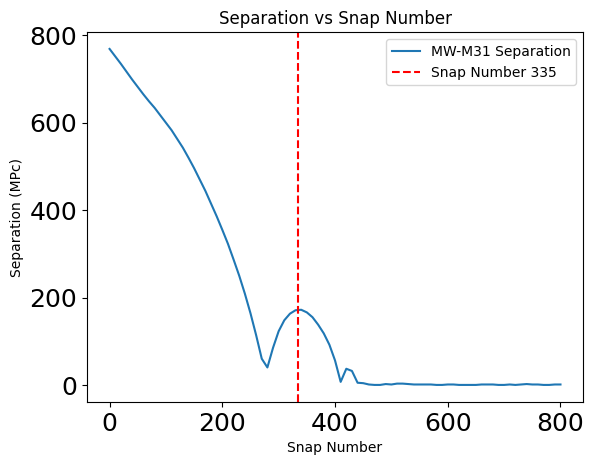

In [10]:
# PLot the separation versus snap number across the simulation
fig, ax = plt.subplots()
ax.plot(snap_ids_total, seps_all, label="MW-M31 Separation")
ax.set_title("Separation vs Snap Number")
ax.set_ylabel("Separation (MPc)")
ax.set_xlabel("Snap Number")
ax.axvline(335, c='r', linestyle='--', label=f"Snap Number {335}")
ax.legend()
plt.show()

In [11]:
# Create an instance of the class for M31 
M31_Curves = Rotation_Curves("M31", snap_ids, r_end=41, dr=1, Res="LowRes")
M31_Curves.Calculate_Rotation_Curves()

# Create an instance of the class for the MW
MW_Curves = Rotation_Curves("MW", snap_ids, r_end=20, dr=1, Res="LowRes")
MW_Curves.Calculate_Rotation_Curves()

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [03:57<00:00,  7.00s/it]


In [12]:
# Calculate the RMSD for M31
M31_Curves.RMSD()
M31_Curves.RMSD_Circular_vs_Observed()

# Calculate the RMSD for MW
MW_Curves.RMSD()
MW_Curves.RMSD_Circular_vs_Observed()

In [13]:
M31_Iniitial_Deviation_Max_Index = np.argmax(M31_Curves.rmsd)
M31_MvO_Max_Index = np.argmax(M31_Curves.rmsd_MvO)
sep_initial_dev_m31 = seps[M31_Iniitial_Deviation_Max_Index]
sep_MvOdev_m31 = seps[M31_MvO_Max_Index]
print(sep_initial_dev_m31, sep_MvOdev_m31)

MW_Iniitial_Deviation_Max_Index = np.argmax(MW_Curves.rmsd)
MW_MvO_Max_Index = np.argmax(MW_Curves.rmsd_MvO)
sep_initial_dev_mw = seps[MW_Iniitial_Deviation_Max_Index]
sep_MvOdev_mw = seps[MW_MvO_Max_Index]
print(sep_initial_dev_mw, sep_MvOdev_mw)

123 123
171 171


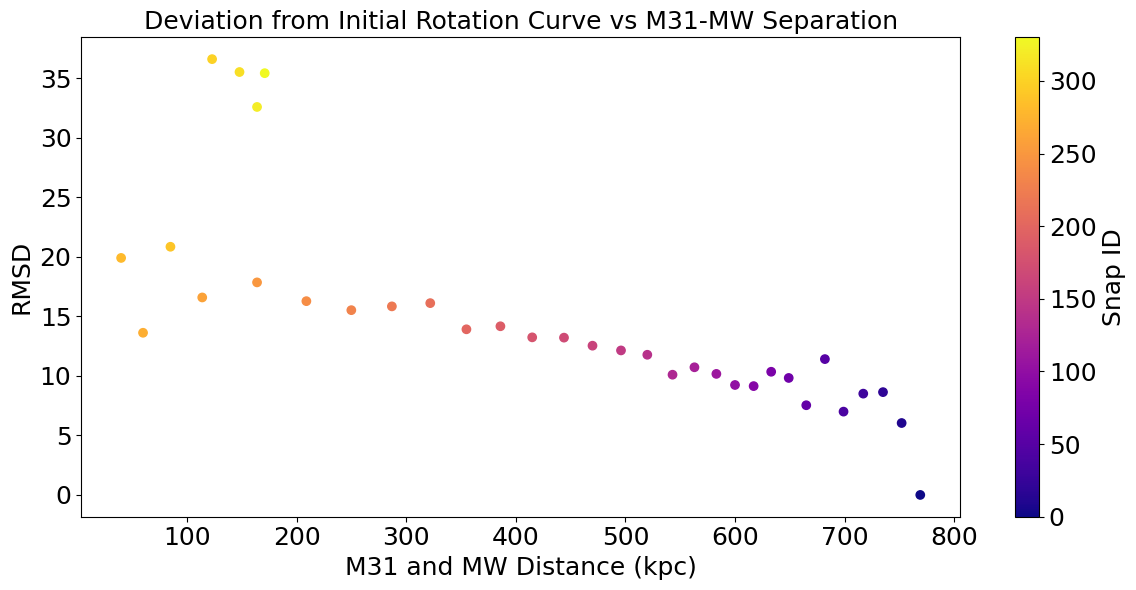

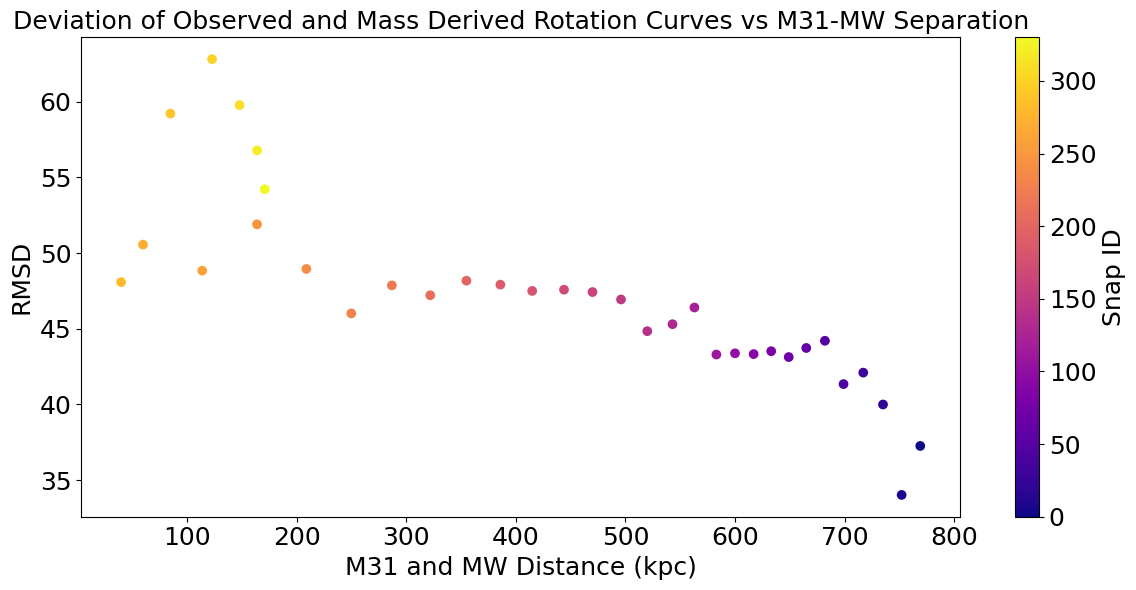

In [22]:
fig, ax = plt.subplots(figsize=(12, 6), layout="tight")
sc = ax.scatter(seps, M31_Curves.rmsd, c=snap_ids, cmap="plasma")
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Snap ID", fontsize=fontsize)

ax.set_xlabel("M31 and MW Distance (kpc)", fontsize=fontsize)
ax.set_ylabel("RMSD", fontsize=fontsize)
ax.set_title("Deviation from Initial Rotation Curve vs M31-MW Separation", fontsize=fontsize)
fig.savefig("RMSD_M31.png")
plt.show()

fig, ax = plt.subplots(figsize=(12, 6), layout="tight")
sc = ax.scatter(seps, M31_Curves.rmsd_MvO, c=snap_ids, cmap="plasma")
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Snap ID", fontsize=fontsize)

ax.set_xlabel("M31 and MW Distance (kpc)", fontsize=fontsize)
ax.set_ylabel("RMSD", fontsize=fontsize)
ax.set_title("Deviation of Observed and Mass Derived Rotation Curves vs M31-MW Separation", fontsize=fontsize)
fig.savefig("RMSD_M31_MvO.png")
plt.show()

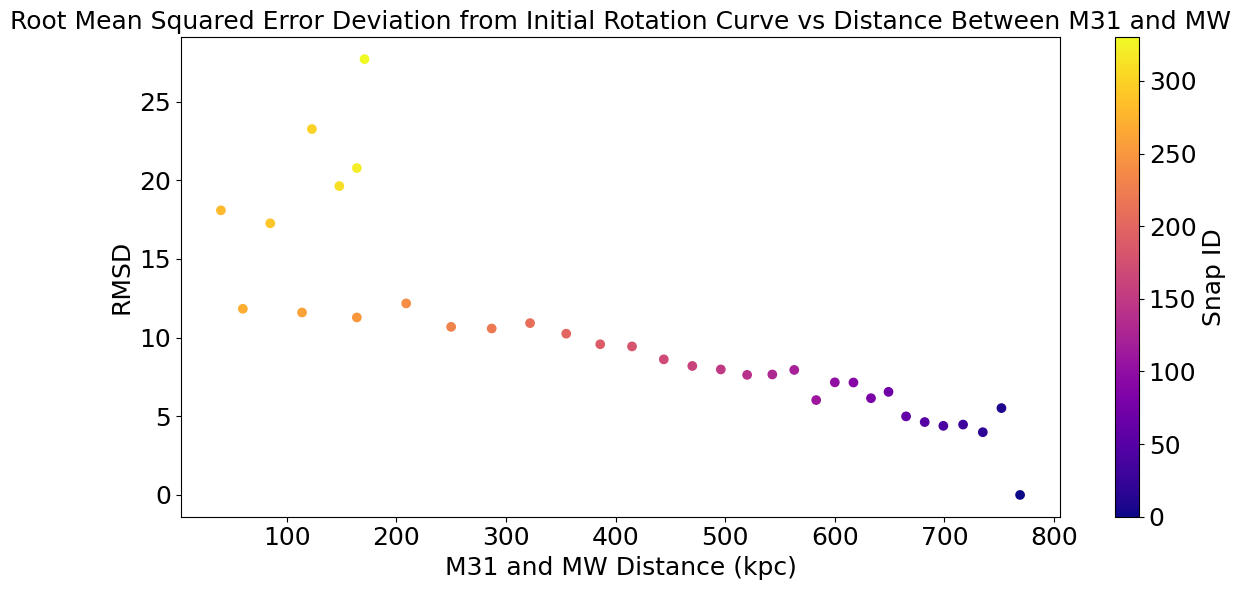

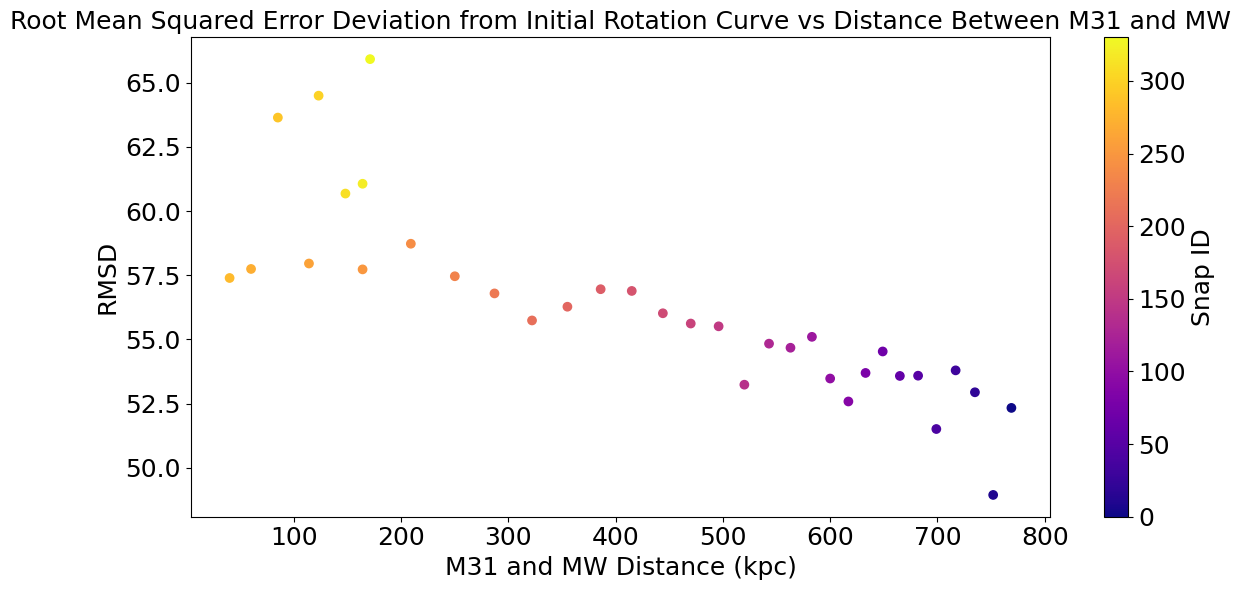

In [23]:
fig, ax = plt.subplots(figsize=(12, 6), layout="tight")
sc = ax.scatter(seps, MW_Curves.rmsd, c=snap_ids, cmap="plasma")
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Snap ID", fontsize=fontsize)

ax.set_xlabel("M31 and MW Distance (kpc)", fontsize=fontsize)
ax.set_ylabel("RMSD", fontsize=fontsize)
ax.set_title("Root Mean Squared Error Deviation from Initial Rotation Curve vs Distance Between M31 and MW", fontsize=fontsize)
fig.savefig("RMSD_MW.png")
plt.show()

fig, ax = plt.subplots(figsize=(12, 6), layout="tight")
sc = ax.scatter(seps, MW_Curves.rmsd_MvO, c=snap_ids, cmap="plasma")
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Snap ID", fontsize=fontsize)

ax.set_xlabel("M31 and MW Distance (kpc)", fontsize=fontsize)
ax.set_ylabel("RMSD", fontsize=fontsize)
ax.set_title("Root Mean Squared Error Deviation from Initial Rotation Curve vs Distance Between M31 and MW", fontsize=fontsize)
fig.savefig("RMSD_MW_MvO.png")
plt.show()

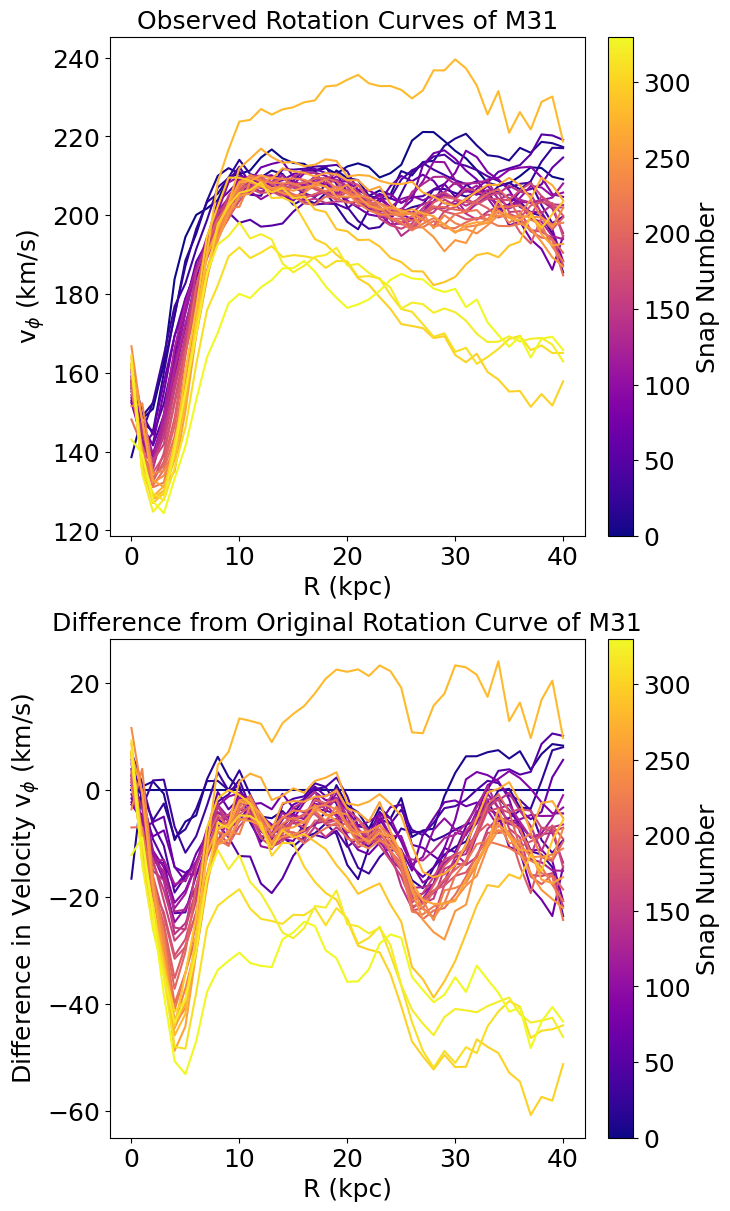

In [16]:
M31_Curves.plot_all_curves(save=True)

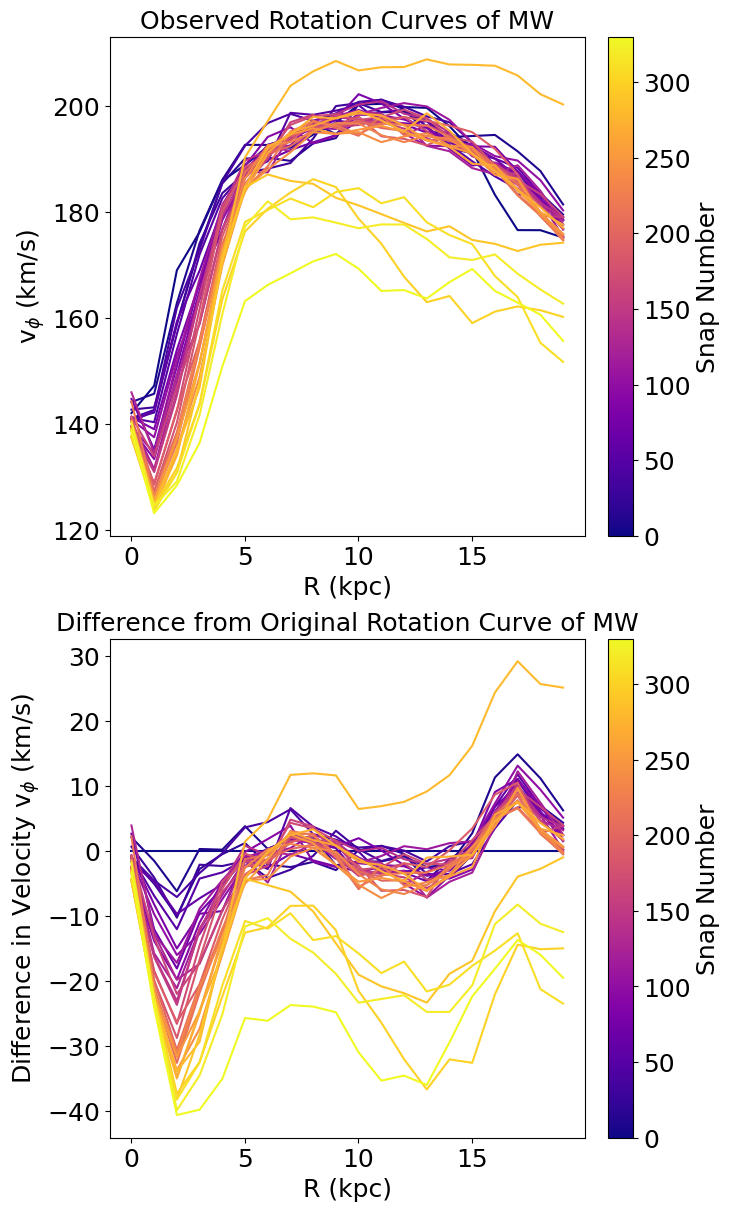

In [17]:
MW_Curves.plot_all_curves(save=True)

In [18]:
# for snap_id in M31_Curves.snap_ids:
    # M31_Curves.plot(snap_id)
    # M31_Curves.plot_residuals(snap_id, save=True)

In [19]:
# for snap_id in snap_ids:
    # MW_Curves.plot(snap_id, xlim=50)
    # MW_Curves.plot_residuals(snap_id, save=True)